# **ML Based Curvature Estimation Within a VOF Framework - Data Generation**



In [1]:
# Import All Needed Libraries
import numpy as np
import pandas as pd

import math
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate Grid

2D Grid Generation Function that generates a simple 2D orthogonal grid.


In [2]:
def genGrid2D(nx, ny, xsize, ysize, plotNow=True, checkNow=True):

    dx = xsize / nx
    dy = ysize / ny

    # Generate grid points
    x = np.linspace(0, xsize, nx+1)
    y = np.linspace(0, ysize, ny+1)

    # Create 2D grid
    X, Y = np.meshgrid(x, y, indexing='xy')

    # Flatten the grid points
    gridPts = np.column_stack((X.ravel(order='C'), Y.ravel(order='C')))

    # Locate centroids
    Centroids = []
    for i in range(ny):
        for j in range(nx):
            centroid_x = (X[i, j] + X[i+1, j] + X[i, j+1] + X[i+1, j+1]) / 4
            centroid_y = (Y[i, j] + Y[i+1, j] + Y[i, j+1] + Y[i+1, j+1]) / 4
            Centroids.append([centroid_x, centroid_y])

    Centroids = np.array(Centroids)
    numElems = len(Centroids)

    # Plot Grid
    if plotNow == True:
      plotGridAndCentroids(gridPts, Centroids, nx, ny, plotNow=True)

    # Check Sample Indicies of Grid
    if checkNow == True:
      checkIdxs(gridPts, Centroids, nx, ny, checkNow=True)

    return dx, dy, gridPts, Centroids, numElems

Plotting Function to visualize generated grid, shows grid points and centroids.

In [7]:
def plotGridAndCentroids(gridPts, Centroids, nx, ny, plotNow=True):
  if plotNow == True:
      # Initialize the plot
        fig, ax = plt.subplots()

        # Plot horizontal lines
        for j in range(nx + 1):
            ax.plot(gridPts[j::nx+1, 0], gridPts[j::nx+1, 1], 'b--', linewidth=1)
        # Plot vertical lines
        for i in range(ny + 1):
            ax.plot(gridPts[i*(nx+1):(i+1)*(nx+1), 0], gridPts[i*(nx+1):(i+1)*(nx+1), 1], 'b--', linewidth=1)

        # Scatter the centroids and gridpts
        ax.scatter(gridPts[:,0], gridPts[:,1], s=10, color='black', label='Grid Points')
        ax.scatter(Centroids[:,0], Centroids[:,1], s=10, color='red', label='Centroids')
        ax.set_xlim(0, max(gridPts[:,0]))
        ax.set_ylim(0, max(gridPts[:,1]))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('2D Grid')
        ax.legend()
        plt.show()

Check Indicies Function to check sample indicies from generated grid point array to ensure correct use of these arrays later.

In [8]:
def checkIdxs(gridPts, Centroids, nx, ny, checkNow=True):
  if checkNow == True:
    for i in range(ny):
        for j in range(nx):
            index = i * nx + j
            bottomLeftIdx = i * (nx + 1) + j                 # P1
            bottomRightIdx = i * (nx + 1) + (j + 1)          # P2
            topLeftIdx = (i + 1) * (nx + 1) + j              # P3
            topRightIdx = (i + 1) * (nx + 1) + (j + 1)       # P4
            if index ==0:
              print("Element Index:",index)
              print("Bottom Left GridPt Index:", bottomLeftIdx, "-- Coordinates:", "(", gridPts[bottomLeftIdx][0], ",", gridPts[bottomLeftIdx][1], ")")
              print("Bottom Right GridPt Index:", bottomRightIdx, "-- Coordinates:", "(", gridPts[bottomRightIdx][0], ",", gridPts[bottomRightIdx][1], ")")
              print("Top Left GridPt Index:", topLeftIdx, "-- Coordinates:", "(", gridPts[topLeftIdx][0], ",", gridPts[topLeftIdx][1], ")")
              print("Top Right GridPt Index:", topRightIdx, "-- Coordinates:", "(", gridPts[topRightIdx][0], ",", gridPts[topRightIdx][1], ")")

            if index == nx*ny-1:
              print("Element Index:",index)
              print("Bottom Left GridPt Index:", bottomLeftIdx, "-- Coordinates:", "(", gridPts[bottomLeftIdx][0], ",", gridPts[bottomLeftIdx][1], ")")
              print("Bottom Right GridPt Index:", bottomRightIdx, "-- Coordinates:", "(", gridPts[bottomRightIdx][0], ",", gridPts[bottomRightIdx][1], ")")
              print("Top Left GridPt Index:", topLeftIdx, "-- Coordinates:", "(", gridPts[topLeftIdx][0], ",", gridPts[topLeftIdx][1], ")")
              print("Top Right GridPt Index:", topRightIdx, "-- Coordinates:", "(", gridPts[topRightIdx][0], ",", gridPts[topRightIdx][1], ")")


Test Run on a simple coarse grid:

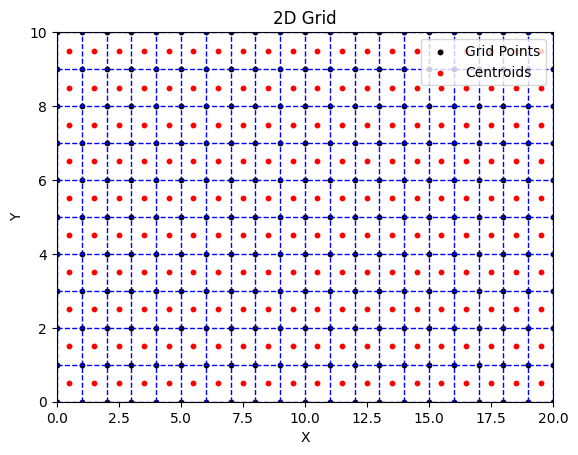

Element Index: 0
Bottom Left GridPt Index: 0 -- Coordinates: ( 0.0 , 0.0 )
Bottom Right GridPt Index: 1 -- Coordinates: ( 1.0 , 0.0 )
Top Left GridPt Index: 21 -- Coordinates: ( 0.0 , 1.0 )
Top Right GridPt Index: 22 -- Coordinates: ( 1.0 , 1.0 )
Element Index: 199
Bottom Left GridPt Index: 208 -- Coordinates: ( 19.0 , 9.0 )
Bottom Right GridPt Index: 209 -- Coordinates: ( 20.0 , 9.0 )
Top Left GridPt Index: 229 -- Coordinates: ( 19.0 , 10.0 )
Top Right GridPt Index: 230 -- Coordinates: ( 20.0 , 10.0 )


In [10]:
# Define grid parameters
nx = 20
ny = 10
xsize = 20
ysize = 10

# Generate Grid
dx, dy, gridPts, Centroids, numElems =genGrid2D(nx, ny, xsize, ysize, plotNow=True, checkNow=True)
# Note:
#   plotNow can be set to False if user does not want to plot gridPts.
#   checkNow can be set to False if user does not want to print some indicies

# Generate Circular Interfaces

Generate a VOF Field based on a circular interface with pre-defined center and radius. Linear approximation of VOF field in each cell based on Euclidean distances from circle center to cell corners.

In [11]:
def genVOFCircularField(dx, dy, nx, ny, numElems, gridPts, Centroids, circleCenter, R, plotNow=True):
    # Initialize volume fraction array
    volFracField = np.zeros((numElems,1))

    # Compute volume fraction
    for i in range(ny):
        for j in range(nx):
            index = i * nx + j

            # Step 1 : Calcualte Distances from Corners to Center
            # Indicies
            bottomLeftIdx = i * (nx + 1) + j                 # P1
            bottomRightIdx = i * (nx + 1) + (j + 1)          # P2
            topLeftIdx = (i + 1) * (nx + 1) + j              # P3
            topRightIdx = (i + 1) * (nx + 1) + (j + 1)       # P4
            # Distancies
            OP1 = math.sqrt((gridPts[topLeftIdx][0]-circleCenter[0])**2 + (gridPts[topLeftIdx][1]-circleCenter[1])**2)
            OP2 = math.sqrt((gridPts[topRightIdx][0]-circleCenter[0])**2 + (gridPts[topRightIdx][1]-circleCenter[1])**2)
            OP3 = math.sqrt((gridPts[bottomLeftIdx][0]-circleCenter[0])**2 + (gridPts[bottomLeftIdx][1]-circleCenter[1])**2)
            OP4 = math.sqrt((gridPts[bottomRightIdx][0]-circleCenter[0])**2 + (gridPts[bottomRightIdx][1]-circleCenter[1])**2)

            # Step 2: Find max
            maxOP = max(OP1,OP2,OP3,OP4)

            # Step 3: Find min
            minOP = min(OP1,OP2,OP3,OP4)

            # Step 4: Estimate Volume Fraction
            if maxOP <= R:
              volFracField[index] = 1
            elif minOP >= R:
              volFracField[index] = 0
            else : # min<R && max>R ==> Interfacial Element
              volFracField[index] = (R-minOP) / (maxOP-minOP)

    # Processing VolField before saving
    volFracField = np.round(volFracField, decimals=6)

    # Plot the contour of volume fraction
    if plotNow ==True:
      plotVOFField(Centroids, gridPts, nx,ny, volFracField, plotNow=True)

    return volFracField

Plot contours of generated VOF field for visualization

In [12]:
def plotVOFField(Centroids, gridPts, nx,ny, volFracField, plotNow=True):
      if plotNow ==True:
        # Initialize the plot
        fig, ax = plt.subplots()

        contour = ax.contourf(Centroids[:,0].reshape((ny, nx)), Centroids[:,1].reshape((ny, nx)), volFracField.reshape((ny, nx)), levels=[0,0.1,0.2 ,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap='coolwarm')
        ax.set_xlim(min(gridPts[:,0]),max(gridPts[:,0]))
        ax.set_ylim(min(gridPts[:,1]),max(gridPts[:,1]))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        cbar = plt.colorbar(contour, ax=ax)
        ax.set_title('Contours of Volume Fraction')
        ax.set_aspect('equal', adjustable='box')
        plt.show()

Test Run on a sample Circular Interface

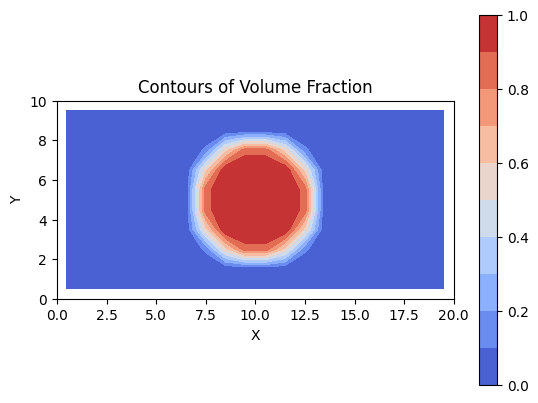

In [14]:
# Define ellipse center
circleCenter = [10, 5]

# Given parameters
R = 3

# Generate Volume Fraction Fields
volFracField = genVOFCircularField(dx, dy, nx, ny, numElems, gridPts, Centroids, circleCenter, R, plotNow=True)
# Note:
#   plotNow can be set to False if user would not like to visualize VOF contour
#   VOF is calcualted for all elements within domain, even boundary elems, however, sometimes boundnary elements are not shown in contour. This is a visual representation bug only.

Save VOF Field if Needed

In [18]:
saveVOF = False

if saveVOF ==True:
    # convert to pandas framework first
    df_vof = pd.DataFrame(volFracField)
    print("Shape of the dataset:", df_vof.shape)

    df_vof.to_excel('VOF_FIELD.xlsx', index=False)

    from google.colab import files
    files.download('VOF_FIELD.xlsx')

# Randomized Dataset Generation

In [21]:
# Generate Grid
nx = 100
ny = 100
xsize = 1
ysize = 1
dx, dy, gridPts, Centroids, numElems =genGrid2D(nx, ny, xsize, ysize, plotNow=False, checkNow=False)

# Needed Input
Rmin = dx * 4
Rmax = dx * 1000

XC = 0.5
YC = 0.5
NS = 100 # Data set size

stencilRadiusSize = 1

Generate a random dataset of NS examples.

In [22]:
# Initialize
dataset = []
randomVars = []
volFracField = []

milestones = {10,20,30,40,50,60,70,80,90,95,99,100} # For printing progress

random.seed(1)
while len(dataset) < NS:
    # Step 1: Choose a seed to start generating random numbers
    # Set the seed if reproducibility is needed
    #
    # Generate a random number with uniform distribution between 0 and 1
    ## U = random.uniform(0, 1)


    # Step 2: Calculate the random radius R
    R = Rmin + random.uniform(0, 1) * (Rmax - Rmin)


    # Step 3: Calculat Random Circle Center
    Xs = XC + random.uniform(0, 1) * dx
    Ys = YC + random.uniform(0, 1) * dy
    circleCenter = [Xs,Ys]

    # Step 4: Calculate Random azimuth angle (theta)
    theta = 2 * math.pi * random.uniform(0, 1)


    # Step 5: Calculate coordinates of the point on the spherical interface
    Xp = Xs + R * math.cos(theta)
    Yp = Ys + R * math.sin(theta)


    # Step 6: Find the indices of the Cartesian cell in which the point (x, y) lies
    ptFoundFlag = False
    # Compute volume fraction
    for i in range(ny):
        for j in range(nx):
            index = i * nx + j
            # Indicies
            bottomLeftIdx = i * (nx + 1) + j                 # P1
            bottomRightIdx = i * (nx + 1) + (j + 1)          # P2
            topLeftIdx = (i + 1) * (nx + 1) + j              # P3
            topRightIdx = (i + 1) * (nx + 1) + (j + 1)       # P4
            # Locate
            if (Xp >= gridPts[bottomLeftIdx][0] and Xp <= gridPts[bottomRightIdx][0] and Yp >= gridPts[bottomLeftIdx][1] and Yp <= gridPts[topLeftIdx][1]):
                ip = i
                jp = j
                ptFoundFlag = True
                break
    if ptFoundFlag == False:
      continue


    # Save random vars for analysis
    randomVars.append((R, Xs, Ys, theta, Xp, Yp))


    # Step 7: Compute Volume Fraction and Curvature
    volFracField = genVOFCircularField(dx, dy, nx, ny, numElems, gridPts, Centroids, circleCenter, R, plotNow=False)
    curvature = 1 / R if R != 0 else 0
    curvature = curvature*dx

    # Create slices to get the neighborhood around (ip, jp). Handle edge cases by taking min/max with grid size.
    i_min = max(ip - stencilRadiusSize, 0)
    i_max = min(ip + stencilRadiusSize + 1, ny)
    j_min = max(jp - stencilRadiusSize, 0)
    j_max = min(jp + stencilRadiusSize + 1, nx)

    # Extract stencil
    volFracStencil = volFracField.reshape(ny, nx)[i_max-1:i_min-1:-1,j_min:j_max]

    if volFracStencil.shape != (2*stencilRadiusSize+1, 2*stencilRadiusSize+1):
      continue
        # # Fill with NaN for initial identification of out-of-bounds
        # paddedStencil = np.empty((2*stencilRadiusSize+1, 2*stencilRadiusSize+1))
        # paddedStencil.fill(np.nan)
        # # Copy existing values into the padded neighborhood
        # paddedStencil[:volFracStencil.shape[0], :volFracStencil.shape[1]] = volFracStencil
        # # Replace NaN with values from surrounding cells
        # for i in range(2*stencilRadiusSize+1):
        #     for j in range(2*stencilRadiusSize+1):
        #         if np.isnan(paddedStencil[i, j]):
        #             # Check row above
        #             if i > 0 and not np.isnan(paddedStencil[i-1, j]):
        #                 paddedStencil[i, j] = paddedStencil[i-1, j]
        #             # Check row below
        #             elif i < 2 and not np.isnan(paddedStencil[i+1, j]):
        #                 paddedStencil[i, j] = paddedStencil[i+1, j]
        #             # Check column left
        #             if j > 0 and not np.isnan(paddedStencil[i, j-1]):
        #                 paddedStencil[i, j] = paddedStencil[i, j-1]
        #             # Check column right
        #             elif j < 2 and not np.isnan(paddedStencil[i, j+1]):
        #                 paddedStencil[i, j] = paddedStencil[i, j+1]
        # volFracStencil = paddedStencil


    # Step 8: Flip Signs
    flipRandomly = np.random.rand() > 0.5
    if flipRandomly:
        curvature = -curvature
        # Invert each cell in the neighborhood volume fraction matrix
        for i in range(2*stencilRadiusSize+1):
          for j in range(2*stencilRadiusSize+1):
            volFracStencil[i, j] = 1 - volFracStencil[i, j]


    # Step 9: Save stencil in dataset
    dataset.append((volFracStencil, curvature))

    # Update and Print Progress
    genPercentage = (len(dataset)/NS)*100
    if int(genPercentage) in milestones:
        print(f"Generation progress: {int(genPercentage)}% completed.")
        milestones.remove(int(genPercentage))

# Step 10: repeat


Generation progress: 10% completed.
Generation progress: 20% completed.
Generation progress: 30% completed.
Generation progress: 40% completed.
Generation progress: 50% completed.
Generation progress: 60% completed.
Generation progress: 70% completed.
Generation progress: 80% completed.
Generation progress: 90% completed.
Generation progress: 95% completed.
Generation progress: 99% completed.
Generation progress: 100% completed.


Save generated dataSet in excel to be used later.

In [23]:
# convert to pandas framework first
data_formatted = [np.append(arr.flatten(), curvature) for arr, curvature in dataset]
df = pd.DataFrame(data_formatted, columns=[f'Cell{i+1}' for i in range((2*stencilRadiusSize+1)**2)] + ['Curvature'])
print("Shape of the dataset:", df.shape)

df.to_excel('Ds1.xlsx', index=False)

from google.colab import files
files.download('Ds1.xlsx')

Shape of the dataset: (100, 26)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualization of Random Variables Distribution

In [24]:
## Save Random Vars used
# Convert to DataFrame for easy handling
columns = ['R', 'Xs', 'Ys', 'Theta', 'Xp', 'Yp']
dfVars = pd.DataFrame(randomVars, columns=columns)

# Optional: Save DataFrame to CSV for later use
dfVars.to_csv('RandomVars_Ds1.csv', index=False)

from google.colab import files
files.download('RandomVars_Ds1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

R/dx vs Frequency Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

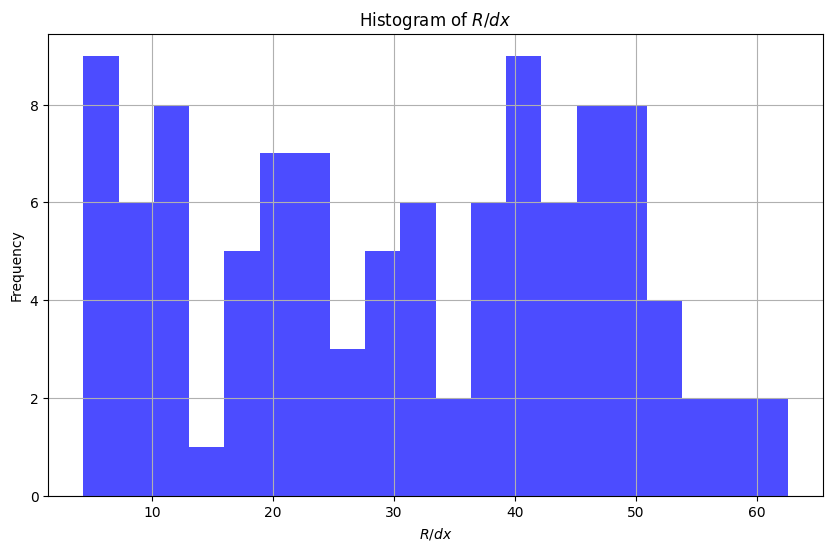

In [30]:
saveRpdx = True   # Save Figure?

dfVars['R_over_dx'] = dfVars['R'] / dx

plt.figure(figsize=(10, 6))
plt.hist(dfVars['R_over_dx'], bins=20, color='blue', alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of $R/dx$')
plt.xlabel('$R/dx$')
plt.ylabel('Frequency')
plt.grid(True)

if saveRpdx:
  plt.savefig('Histogram_of_R_over_dx.png')  # Save the figure
  files.download('Histogram_of_R_over_dx.png')  # Download the figure

Circle Center Distribution Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

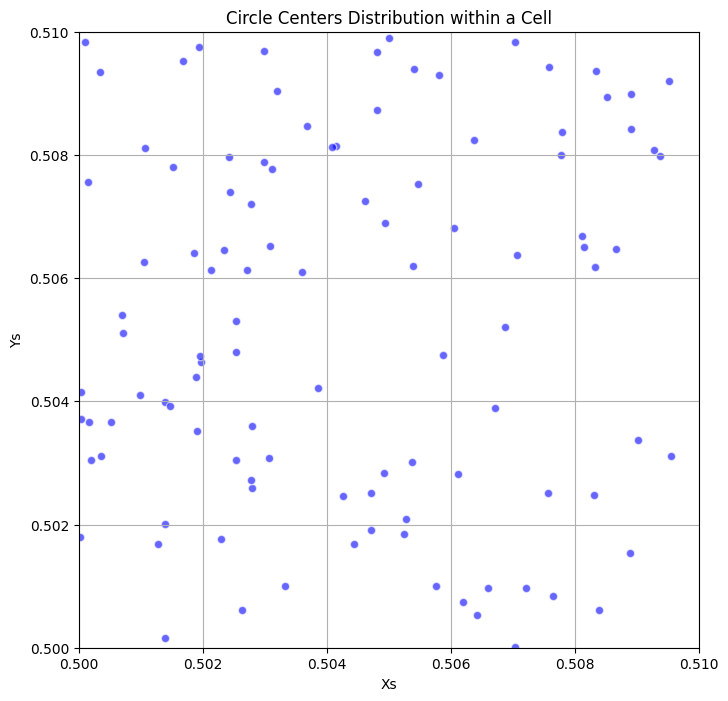

In [26]:
saveCCD = True    # Save Figure?

plt.figure(figsize=(8, 8))
plt.scatter(dfVars['Xs'], dfVars['Ys'], alpha=0.6, edgecolors='w', color='blue')
plt.title('Circle Centers Distribution within a Cell')
plt.xlabel('Xs')
plt.ylabel('Ys')
plt.grid(True)
plt.xlim(XC,XC + dx)
plt.ylim(YC,YC + dy)

if saveCCD:
  plt.savefig('Circle Center.png')
  files.download('Circle Center.png')

Theta Vs Frequency Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

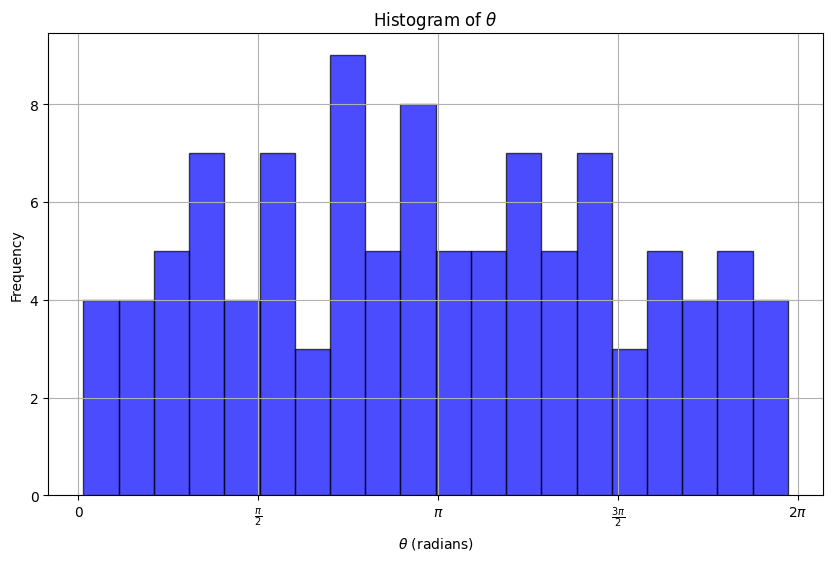

In [32]:
saveTheta = True # Save Figure?

plt.figure(figsize=(10, 6))
plt.hist(dfVars['Theta'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of $\\theta$')
plt.xlabel('$\\theta$ (radians)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', '$\\frac{\\pi}{2}$', '$\\pi$', '$\\frac{3\\pi}{2}$', '$2\\pi$'])

if saveTheta:
    plt.savefig('Theta.png')
    files.download('Theta.png')